# COVID-19 India: A data scientist's perspective

### Imports

In [63]:
import requests
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### Using dataset available at covid19india.org

In [64]:
req = requests.get("https://api.covid19india.org/raw_data.json").json()
df = pd.DataFrame.from_dict(req['raw_data'])

In [65]:
df.columns

Index(['agebracket', 'backupnotes', 'contractedfromwhichpatientsuspected',
       'currentstatus', 'dateannounced', 'detectedcity', 'detecteddistrict',
       'detectedstate', 'estimatedonsetdate', 'gender', 'nationality', 'notes',
       'patientnumber', 'source1', 'source2', 'source3', 'statecode',
       'statepatientnumber', 'statuschangedate', 'typeoftransmission'],
      dtype='object')

In [66]:
print("Shape of the dataframe : \n\trows : {}\n\tcolumns : {}\n".format(df.shape[0], df.shape[1]))
columns = df.columns
print("\nColumns present in the dataframe : {}".format(columns))

Shape of the dataframe : 
	rows : 27891
	columns : 20


Columns present in the dataframe : Index(['agebracket', 'backupnotes', 'contractedfromwhichpatientsuspected',
       'currentstatus', 'dateannounced', 'detectedcity', 'detecteddistrict',
       'detectedstate', 'estimatedonsetdate', 'gender', 'nationality', 'notes',
       'patientnumber', 'source1', 'source2', 'source3', 'statecode',
       'statepatientnumber', 'statuschangedate', 'typeoftransmission'],
      dtype='object')


### Cleaning the data


In [67]:
df = df.drop(['source1', 'source2', 'source3'], axis = 1)

In [68]:
df.dateannounced = pd.to_datetime(df['dateannounced'])

df.statuschangedate = pd.to_datetime(df['statuschangedate'])

### State wise recorvered and deceased count


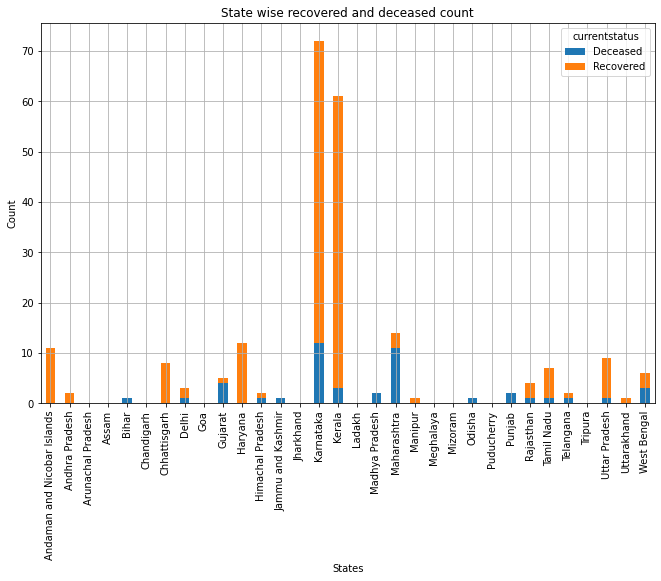

In [69]:
#Filter data and remove empty detectedstate
status_df = df[df.detectedstate != '']
status = status_df.groupby(['detectedstate', 'currentstatus']).size().reset_index(name='count').pivot(columns='currentstatus', index='detectedstate', values='count')
status = status.fillna(0)


status = status.drop(['Migrated', 'Hospitalized'], axis = 1)
status.plot(kind='bar', stacked=True, figsize=(11,7))
plt.xlabel("States")
plt.ylabel("Count")
plt.title("State wise recovered and deceased count")
plt.grid(True)
plt.show()

### Distribution of cases in States between local and fore cases

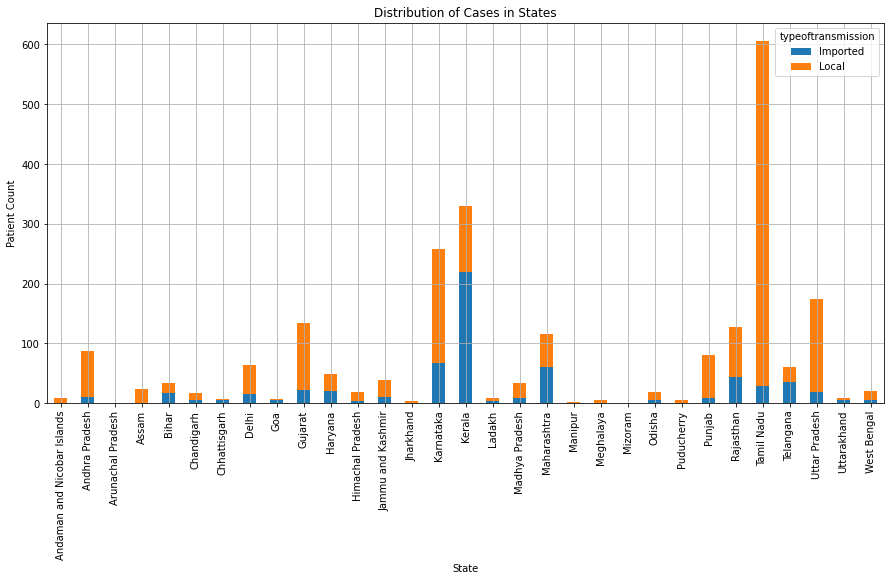

In [70]:
transmission_df = df[df.typeoftransmission != '']
transmission_df = transmission_df[transmission_df.typeoftransmission != 'TBD']
statewisetransmission = transmission_df.groupby(['detectedstate', 'typeoftransmission']).size().reset_index(name='count').pivot(columns='typeoftransmission', index='detectedstate', values='count')
imported_local = statewisetransmission[['Imported', 'Local']]

imported_local = imported_local.fillna(0)
imported_local.plot(kind='bar', stacked=True, figsize=(15,7))
plt.xlabel("State")
plt.ylabel("Patient Count")
plt.title("Distribution of Cases in States")
plt.grid(True)
plt.show()


### Age-Range Distribution 

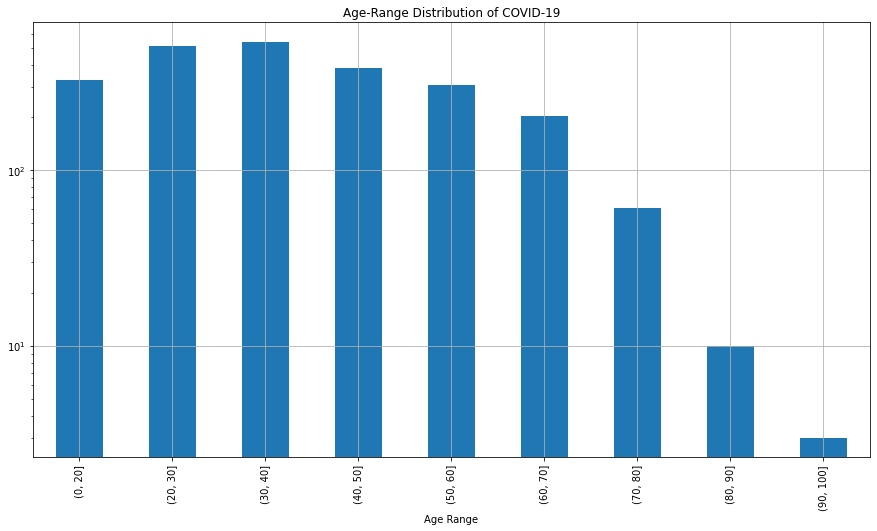

In [71]:
dropInvalidAge = lambda age : str(age).isdigit()

agebracket_df = df[df.agebracket != '']
agebracket = agebracket_df.agebracket
agebracket = agebracket[agebracket.apply(dropInvalidAge)]
floatAge = agebracket.astype(float)

age_bins = [0,20,30,40,50,60,70,80,90,100]
age_seg = pd.cut(floatAge, age_bins)

agebracketgroups = age_seg.reset_index().groupby('agebracket').size()
agebracketgroups.plot(kind='bar',  figsize=(15,8))
plt.xticks(rotation=90)
plt.xlabel("Age Range")
plt.yscale('log')
plt.title("Age-Range Distribution of COVID-19")
plt.grid(True)
plt.show()

### Top 5 states with highest average of community spread

In [72]:
chain_df = df[df.contractedfromwhichpatientsuspected.str.startswith('P')]

chain_count = 0

def build_recursive_chain(patient_id) : 
    global chain_count
    if patient_id.empty : 
        return
    else :
        chain_count = chain_count + 1
        patient_id = list(patient_id)[0].replace('P', '')
        temp_df = chain_df[chain_df.patientnumber == patient_id]
        build_recursive_chain(temp_df.contractedfromwhichpatientsuspected)
        

def compute_chain(row) :
    global chain_count
    chain_count = 0
    build_recursive_chain(patient_id = pd.Series(row.contractedfromwhichpatientsuspected))
    return chain_count


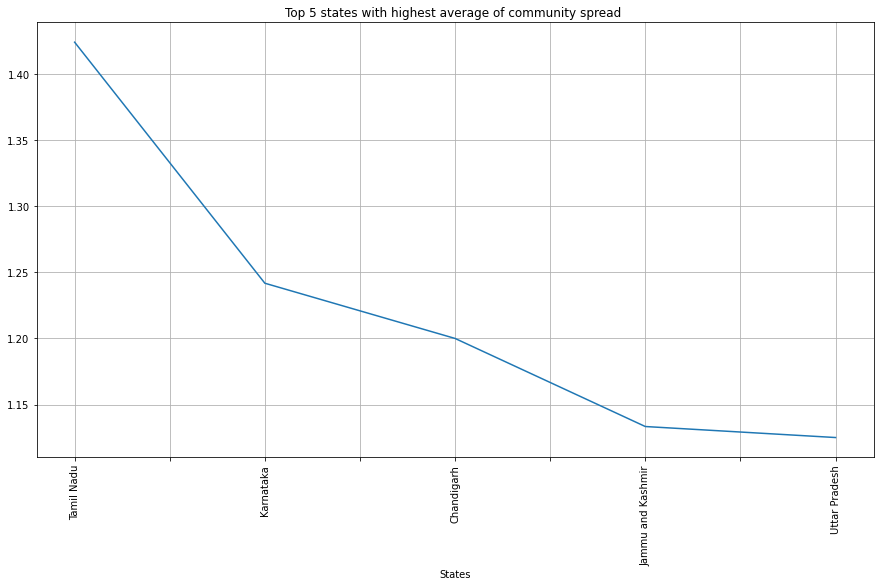

In [73]:
chain_df_copy = chain_df.copy()
for index, row in chain_df.iterrows():
    chain_df_copy.loc[index, 'chainlength'] = compute_chain(row);
    
    
chain_group = chain_df_copy.groupby(['detectedstate'])
top_states = chain_group.mean().sort_values(by='chainlength', ascending=False)[:5]
top_states.plot(figsize=(15,8), legend=False)
plt.xticks(rotation=90)
plt.xlabel("States")
plt.title("Top 5 states with highest average of community spread ")
plt.grid(True)
plt.show()

### Gender Distribution

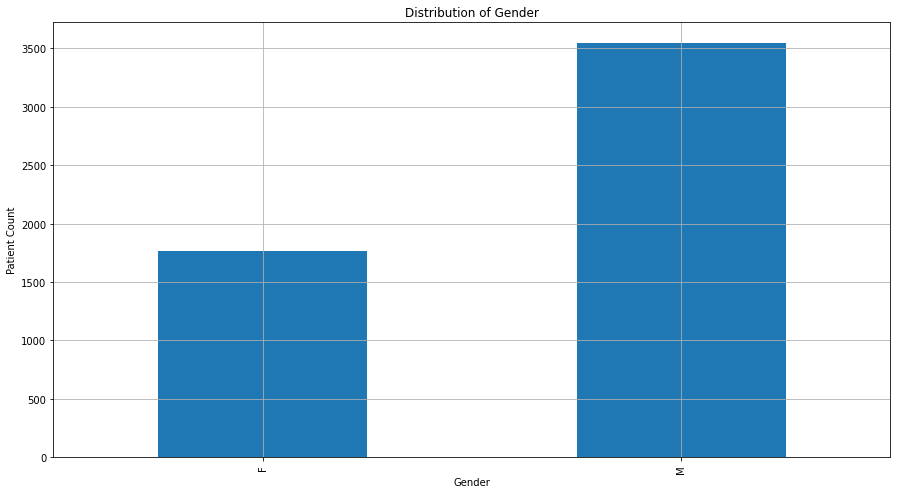

In [74]:
# Gender distribution
gender_df = df[df.gender != '']
gender = gender_df.groupby('gender').size()

gender.reset_index(name='count')

gender.plot(kind='bar', figsize=(15,8))
plt.xlabel("Gender")
plt.ylabel("Patient Count")
plt.title("Distribution of Gender")
plt.grid(True)
plt.show()